In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

2024-03-30 19:49:03.574538: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-30 19:49:03.621529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 19:49:03.621571: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 19:49:03.621593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 19:49:03.631069: I tensorflow/core/platform/cpu_feature_g

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


2024-03-30 19:50:39.961857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 19:50:40.098175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 19:50:40.098327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 19:50:40.103431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 19:50:40.103480: I tensorflow/compile

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [3]:
class_names=train_dataset.class_names

In [4]:
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

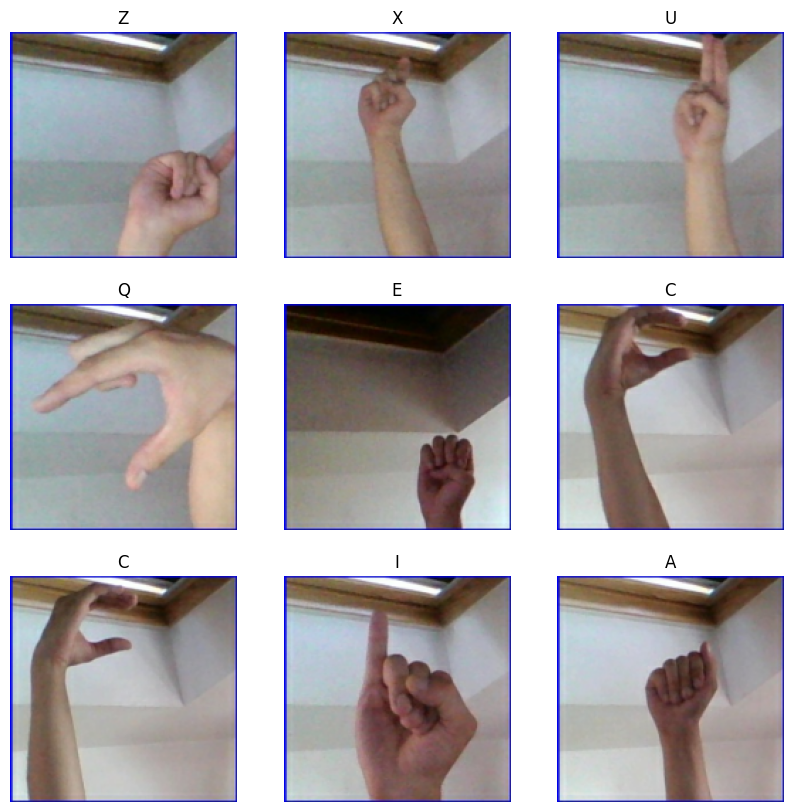

In [5]:

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [6]:
def to_one_hot(y, num_classes=29):
    return tf.one_hot(y, num_classes)


train_dataset = train_dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))

train_dataset = train_dataset.map(lambda x, y: (x, to_one_hot(y)))
validation_dataset = validation_dataset.map(lambda x, y: (x, to_one_hot(y)))

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
def data_augmenter():
 
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
 
    
    return data_augmentation

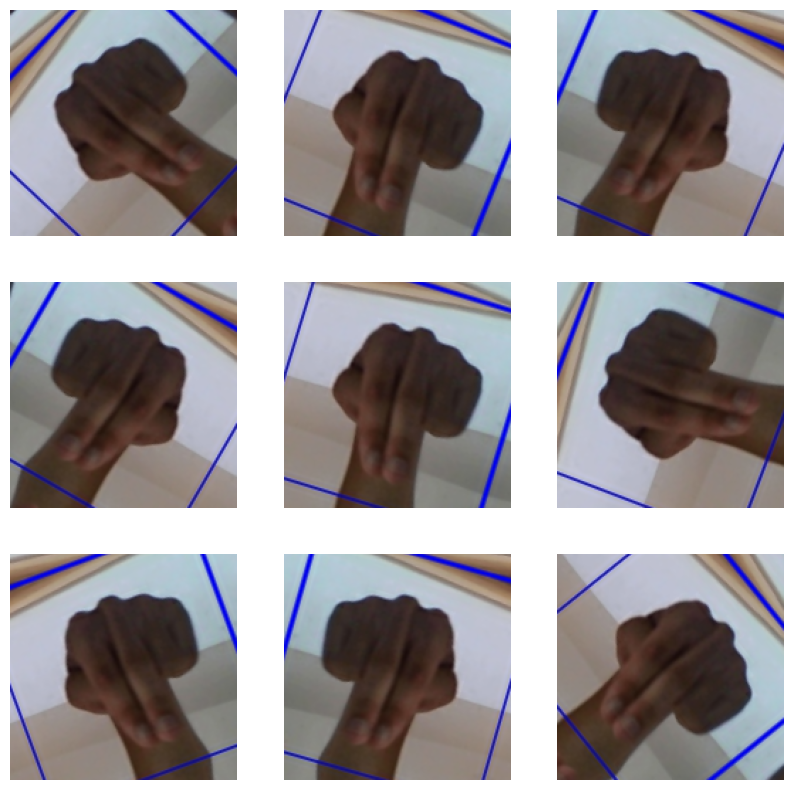

In [9]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [11]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def custom_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
  
    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape) 
    

    x = data_augmentation(inputs)
    x = preprocess_input(x) 

    x = base_model(x, training=False)
    

    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x = tf.keras.layers.Dropout(0.2)(x)
    

    outputs = tf.keras.layers.Dense(29, activation="linear")(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model


In [12]:

model = custom_model(IMG_SIZE, data_augmentation)

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])


initial_epochs = 10
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)


Epoch 1/10


2024-03-30 19:52:23.207568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-03-30 19:52:25.239094: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-30 19:52:27.258193: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f195419dd90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-30 19:52:27.258259: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-03-30 19:52:27.266893: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-30 19:52:27.382565: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2175/2175 [==============================] - 96s 40ms/step - loss: 1.0185 - accuracy: 0.7004 - val_loss: 0.3827 - val_accuracy: 0.8860
Epoch 2/10
2175/2175 [==============================] - 83s 38ms/step - loss: 0.5628 - accuracy: 0.8206 - val_loss: 0.3238 - val_accuracy: 0.8969
Epoch 3/10
2175/2175 [==============================] - 88s 40ms/step - loss: 0.4889 - accuracy: 0.8427 - val_loss: 0.2734 - val_accuracy: 0.9077
Epoch 4/10
2175/2175 [==============================] - 90s 41ms/step - loss: 0.4638 - accuracy: 0.8482 - val_loss: 0.2675 - val_accuracy: 0.9128
Epoch 5/10
2175/2175 [==============================] - 89s 41ms/step - loss: 0.4433 - accuracy: 0.8537 - val_loss: 0.2397 - val_accuracy: 0.9236
Epoch 6/10
2175/2175 [==============================] - 94s 43ms/step - loss: 0.4354 - accuracy: 0.8573 - val_loss: 0.2583 - val_accuracy: 0.9153
Epoch 7/10
2175/2175 [==============================] - 91s 42ms/step - loss: 0.4226 - accuracy: 0.8637 - val_loss: 0.2576 - val_accura

In [13]:

checkpoint_dir = './mnetsaved_checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)


checkpoint_path = os.path.join(checkpoint_dir, 'model_weights')


model.save_weights(checkpoint_path)

[0.0, 0.7004454135894775, 0.8205890655517578, 0.8427011370658875, 0.8482327461242676, 0.8536638021469116, 0.8572701215744019, 0.8637068867683411, 0.8613505959510803, 0.8668822050094604, 0.8646839261054993]


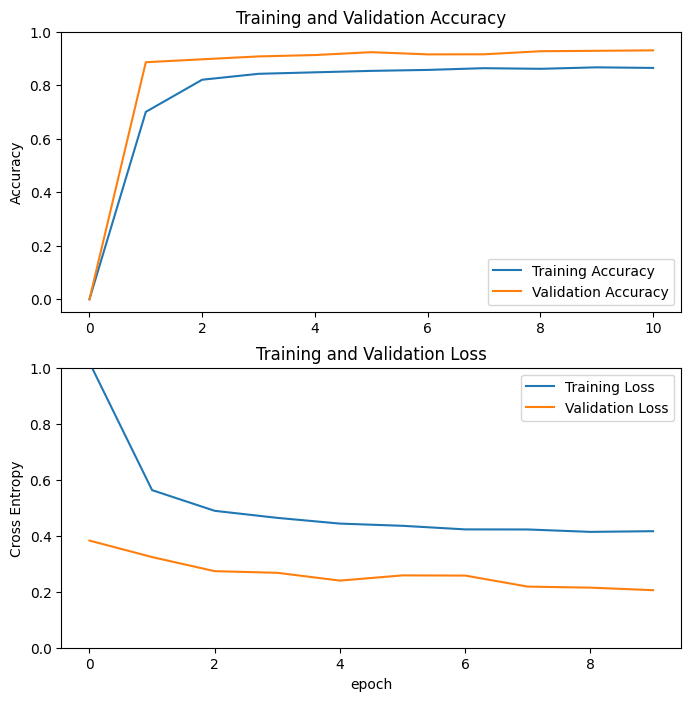

In [14]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
print(acc)
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 1s/step
Predicted class: 27 - Name: nothing
1/1 [==============================] - 0s 58ms/step


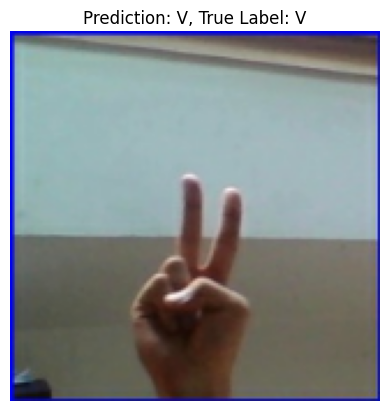

1/1 [==============================] - 0s 40ms/step


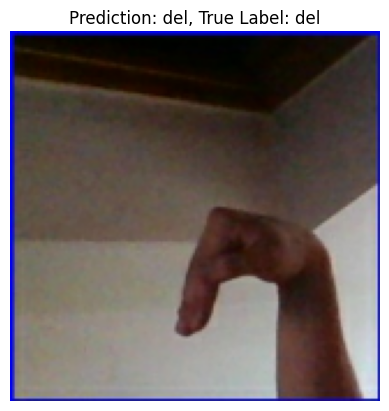

1/1 [==============================] - 0s 30ms/step


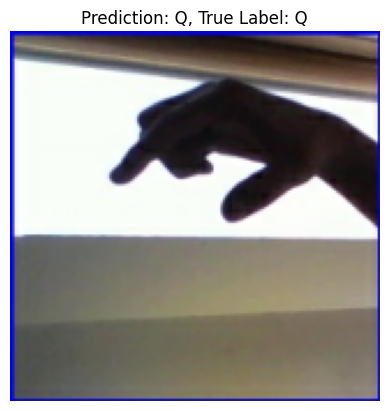

1/1 [==============================] - 0s 40ms/step


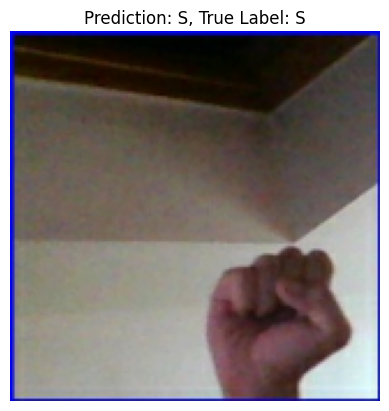

1/1 [==============================] - 0s 33ms/step


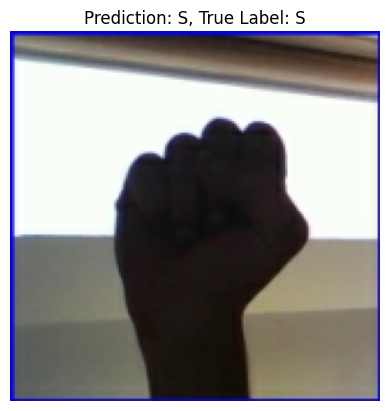

1/1 [==============================] - 0s 34ms/step


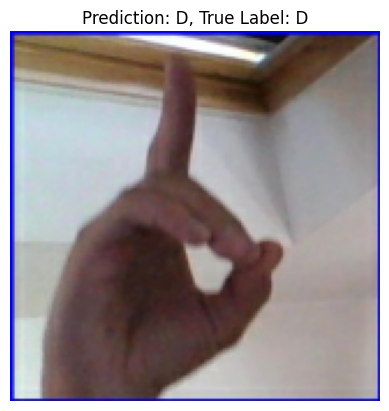

1/1 [==============================] - 0s 36ms/step


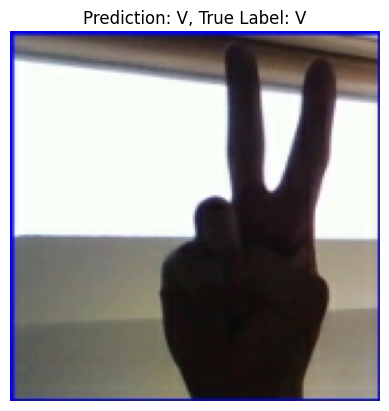

1/1 [==============================] - 0s 35ms/step


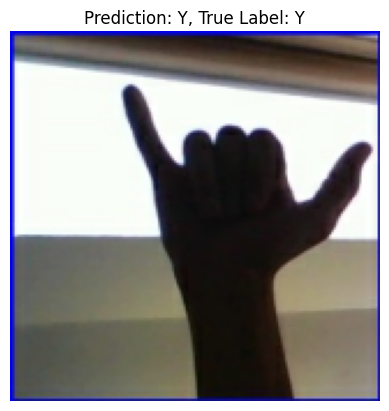

1/1 [==============================] - 0s 39ms/step


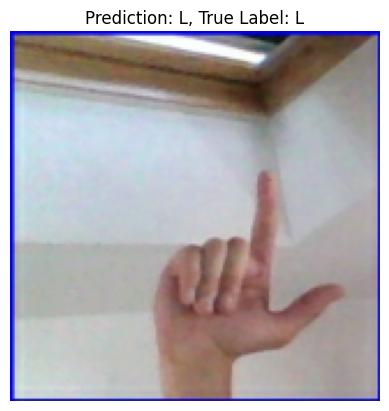

1/1 [==============================] - 0s 39ms/step


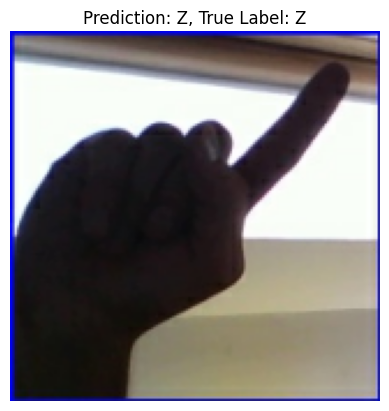

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img = load_img(image_path, target_size=IMG_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)


predictions = model.predict(x)
predicted_class = np.argmax(predictions[0])
print(f"Predicted class: {predicted_class} - Name: {class_names[predicted_class]}")


import matplotlib.pyplot as plt

def display_prediction(image, prediction, true_label):
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {prediction}, True Label: {true_label}")
    plt.show()
random_indices = np.random.choice(len(validation_dataset), size=10, replace=False)

for i, (image, label) in enumerate(validation_dataset.take(10)):
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction, axis=1)[0]
    predicted_class = class_names[predicted_label]
    true_class = class_names[np.argmax(label, axis=1)[0]]
    display_prediction(image[0].numpy().astype("uint8"), predicted_class, true_class)